# Review Notebook: Waveform Generation

This waveform shows that the `time-domain-gw-inference` code and `bilby` generate identical waveforms.

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify 
import bilby
from scipy.stats import norm, gaussian_kde
import shutil
from tqdm import tqdm
import lal

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
cmap1 = sns.color_palette('colorblind')
cmap2 = sns.color_palette('dark')

import sys, os
sys.path.append('/home/simona.miller/time-domain-gw-inference')
from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

os.environ["LAL_DATA_PATH"] = "/mnt/home/smiller/src/waveforms"

Set up the parameters for the system we want to look at

In [2]:
# Three detector-network
ifos = ['H1', 'L1', 'V1']

# run with the surrogate
wf_approx = 'NRSur7dq4'

# define BBH parameters for the system
injection = {
    'total_mass':100,
    'mass_ratio':0.8,
    'spin1_x':0.03,
    'spin1_y':0.05,
    'spin1_z':0.4,
    'spin2_x':0.06,
    'spin2_y':0.2,
    'spin2_z':0.3,
    'inclination':0.5,
    'right_ascension':1.5,
    'declination':2.4,
    'polarization':0.5,
    'geocenter_time': 1126259462.391, 
    'luminosity_distance':1000,
    'inclination':1.7,
    'phase':3.1
}

# define reference frequencies
f22_start=0
f_ref=11
f_low = 20

# sampling
sampling_freq = 2048
dt = 1/sampling_freq

# time steps to generate signal over
post_trigger_duration = 1
pre_trigger_duration = 3
time_array = np.arange(injection['geocenter_time'] - pre_trigger_duration, injection['geocenter_time'] + post_trigger_duration + dt, dt)
time_dict = {ifo:time_array for ifo in ifos}

# from these, calcualte the start time and duration
start_time = time_array[0]
duration = time_array[-1] - start_time

## Generate waveform with time domain code

The `time-domain-gw-inference` code has a `WaveformManager` class which we will use for our waveform generation. 

In [3]:
wf_manager = utils.likelihood.WaveformManager(
    ifos,
    approx=wf_approx, 
    right_ascension=injection['right_ascension'], 
    declination=injection['declination'],
    polarization=injection['polarization'],
    geocenter_time=injection['geocenter_time'],
    mtot_lim=[60,300], 
    q_lim=[0.16, 1],
    dist_lim=[100,10000],
    chi_lim=[0,1], 
)

Generate the plus and cross polarizations

In [4]:
hp_td, hc_td = wf_manager.get_hplus_hcross(injection, dt, f22_start, f_ref)
h_polarizations_td = {'plus': hp_td, 'cross':hc_td} # put in a dict for convenient plotting

Generate the detector projections

In [5]:
h_ifos_td = wf_manager.get_projected_waveform(injection, ifos, time_dict, f22_start, f_ref)

## Generate waveform with `bilby`

We here use the `WaveformGenerator` class in `bilby`:

In [6]:
# Set up waveform generator 
wf_generator_bilby = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_freq,
    start_time=start_time,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments={
        'minimum_frequency':f22_start,
        'maximum_frequency':sampling_freq / 2, # Nyquist frequency is sampling frequency / 2
        'reference_frequency':f_ref,
        'waveform_approximant':wf_approx
    }
)

20:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Inject the same signal as above, but first, change labeling convention to fit `bilby`:

In [7]:
# transform masses
m1, m2 = utils.m1m2_from_mtotq(injection['total_mass'], injection['mass_ratio'])

# transform spins/angles
thetaJN, phiJL, theta1, theta2, phi12, chi1, chi2 = utils.transformPrecessingWvf2PE(
    injection['inclination'], 
    injection['spin1_x'], 
    injection['spin1_y'],
    injection['spin1_z'],
    injection['spin2_x'],
    injection['spin2_y'], 
    injection['spin2_z'],  
    m1, 
    m2, 
    f_ref, 
    injection['phase']
)

injection_bilby = {
    'mass_1':m1,
    'mass_2':m2,
    'a_1':chi1,
    'a_2':chi2,
    'tilt_1':theta1,
    'tilt_2':theta2,
    'phi_12':phi12,
    'phi_jl':phiJL,
    'luminosity_distance':injection['luminosity_distance'],
    'theta_jn':thetaJN,
    'phase':injection['phase'], 
    'ra':injection['right_ascension'], 
    'dec':injection['declination'], 
    'psi':injection['polarization'], 
    'geocent_time':injection['geocenter_time'], 
}

# Get time-domain strain
wf_bilby = wf_generator_bilby.time_domain_strain(injection_bilby)

# Rolling it backwards so times align
wf_bilby['plus'] = np.roll(wf_bilby['plus'], -post_trigger_duration * wf_generator_bilby.sampling_frequency)
wf_bilby['cross'] = np.roll(wf_bilby['cross'], -post_trigger_duration * wf_generator_bilby.sampling_frequency)

Project onto detectors

In [8]:
ifo_list_bilby = bilby.gw.detector.InterferometerList(ifos)
for IFO in ifo_list_bilby:
    IFO.set_strain_data_from_zero_noise(sampling_freq, duration, start_time)
    IFO.inject_signal(parameters=injection_bilby, waveform_generator=wf_generator_bilby)

20:59 bilby INFO    : Injected signal in H1:
20:59 bilby INFO    :   optimal SNR = 12.68
20:59 bilby INFO    :   matched filter SNR = 12.68+0.00j
20:59 bilby INFO    :   mass_1 = 55.55555555555556
20:59 bilby INFO    :   mass_2 = 44.44444444444444
20:59 bilby INFO    :   a_1 = 0.4042276586281548
20:59 bilby INFO    :   a_2 = 0.3655133376499413
20:59 bilby INFO    :   tilt_1 = 0.1447542015866123
20:59 bilby INFO    :   tilt_2 = 0.6080501183026739
20:59 bilby INFO    :   phi_12 = 0.24896270579271707
20:59 bilby INFO    :   phi_jl = 1.159456718713173
20:59 bilby INFO    :   luminosity_distance = 1000
20:59 bilby INFO    :   theta_jn = 1.7434837023931609
20:59 bilby INFO    :   phase = 3.1
20:59 bilby INFO    :   ra = 1.5
20:59 bilby INFO    :   dec = 2.4
20:59 bilby INFO    :   psi = 0.5
20:59 bilby INFO    :   geocent_time = 1126259462.391
20:59 bilby INFO    : Injected signal in L1:
20:59 bilby INFO    :   optimal SNR = 13.84
20:59 bilby INFO    :   matched filter SNR = 13.84+0.00j
20:5

## Plot the comparisons

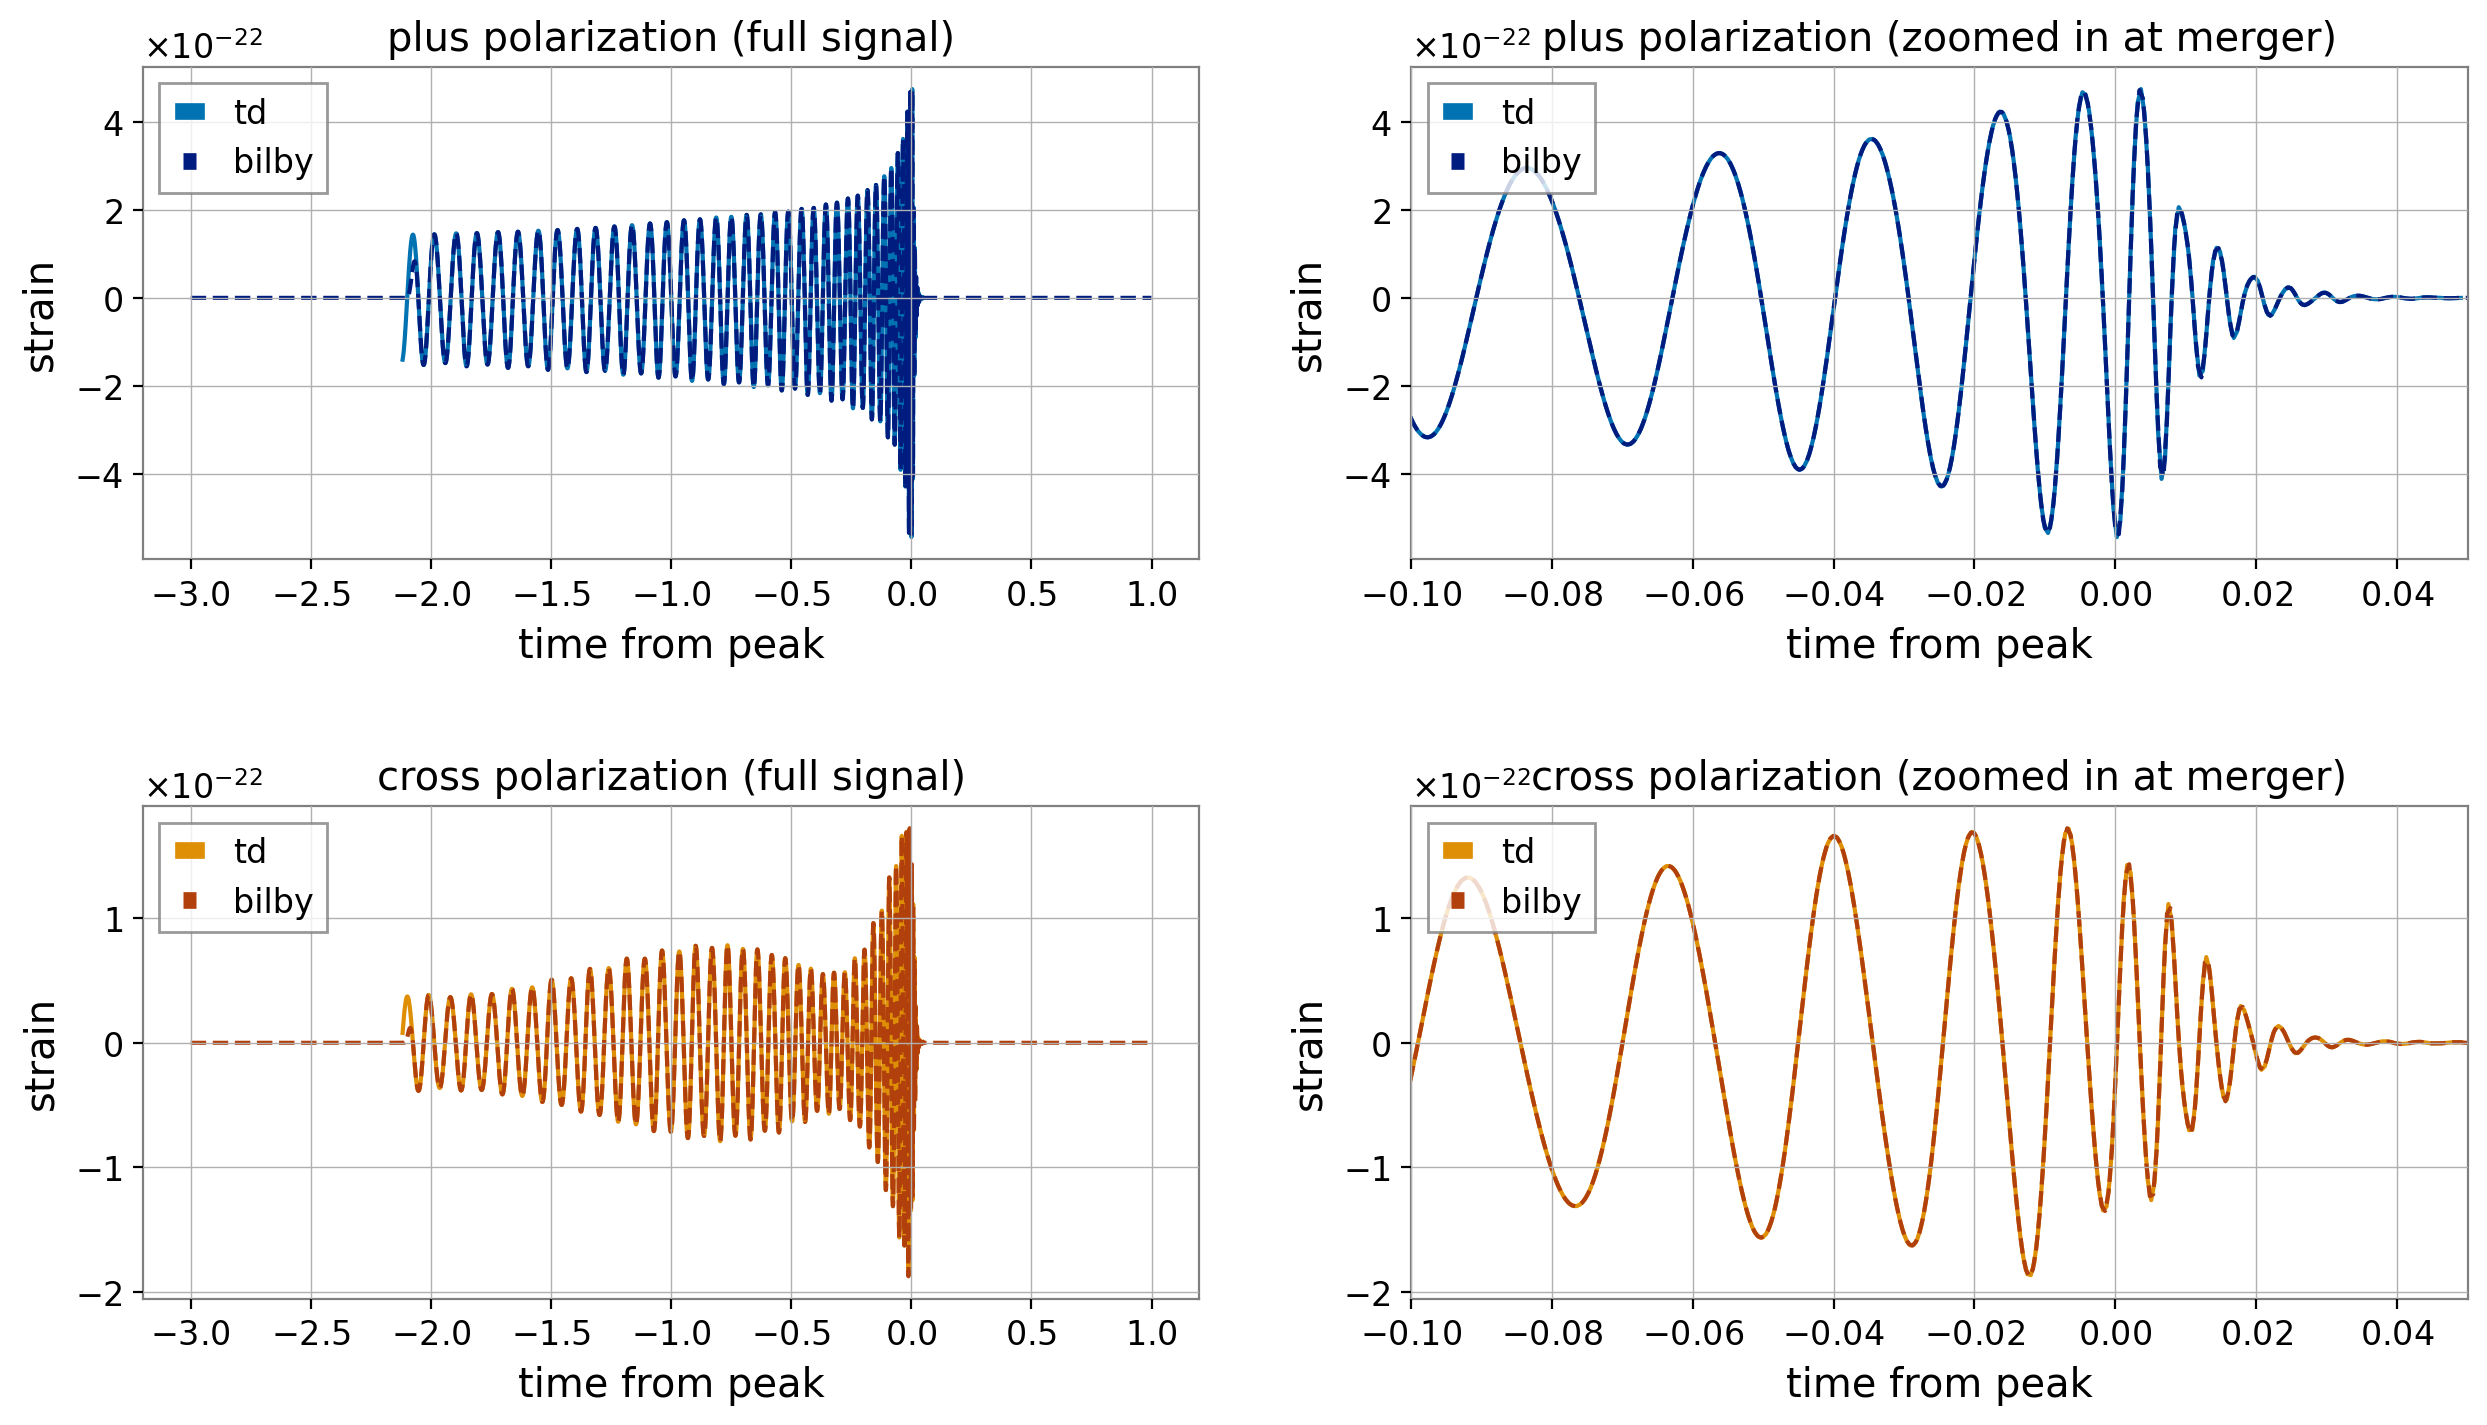

In [9]:
# Plus and cross polarization
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

for i, k in enumerate(h_polarizations_td.keys()): 

    for ax in axes[i]:
        # td
        ax.plot(h_polarizations_td[k].times.value, h_polarizations_td[k], color=cmap1[i], label='td')
    
        # bilby
        ax.plot(wf_generator_bilby.time_array - injection['geocenter_time'], wf_bilby[k], color=cmap2[i], ls='--', label='bilby')
        
        ax.set_xlabel('time from peak')
        ax.set_ylabel('strain')
        ax.legend(loc='upper left')


    axes[i][0].set_title(k+' polarization (full signal)')
    axes[i][1].set_title(k+' polarization (zoomed in at merger)')

    axes[i][1].set_xlim(-0.1, 0.05)
        
plt.subplots_adjust(hspace=0.5)
plt.show()

They agree!

Now, plot the projections onto the detectors.

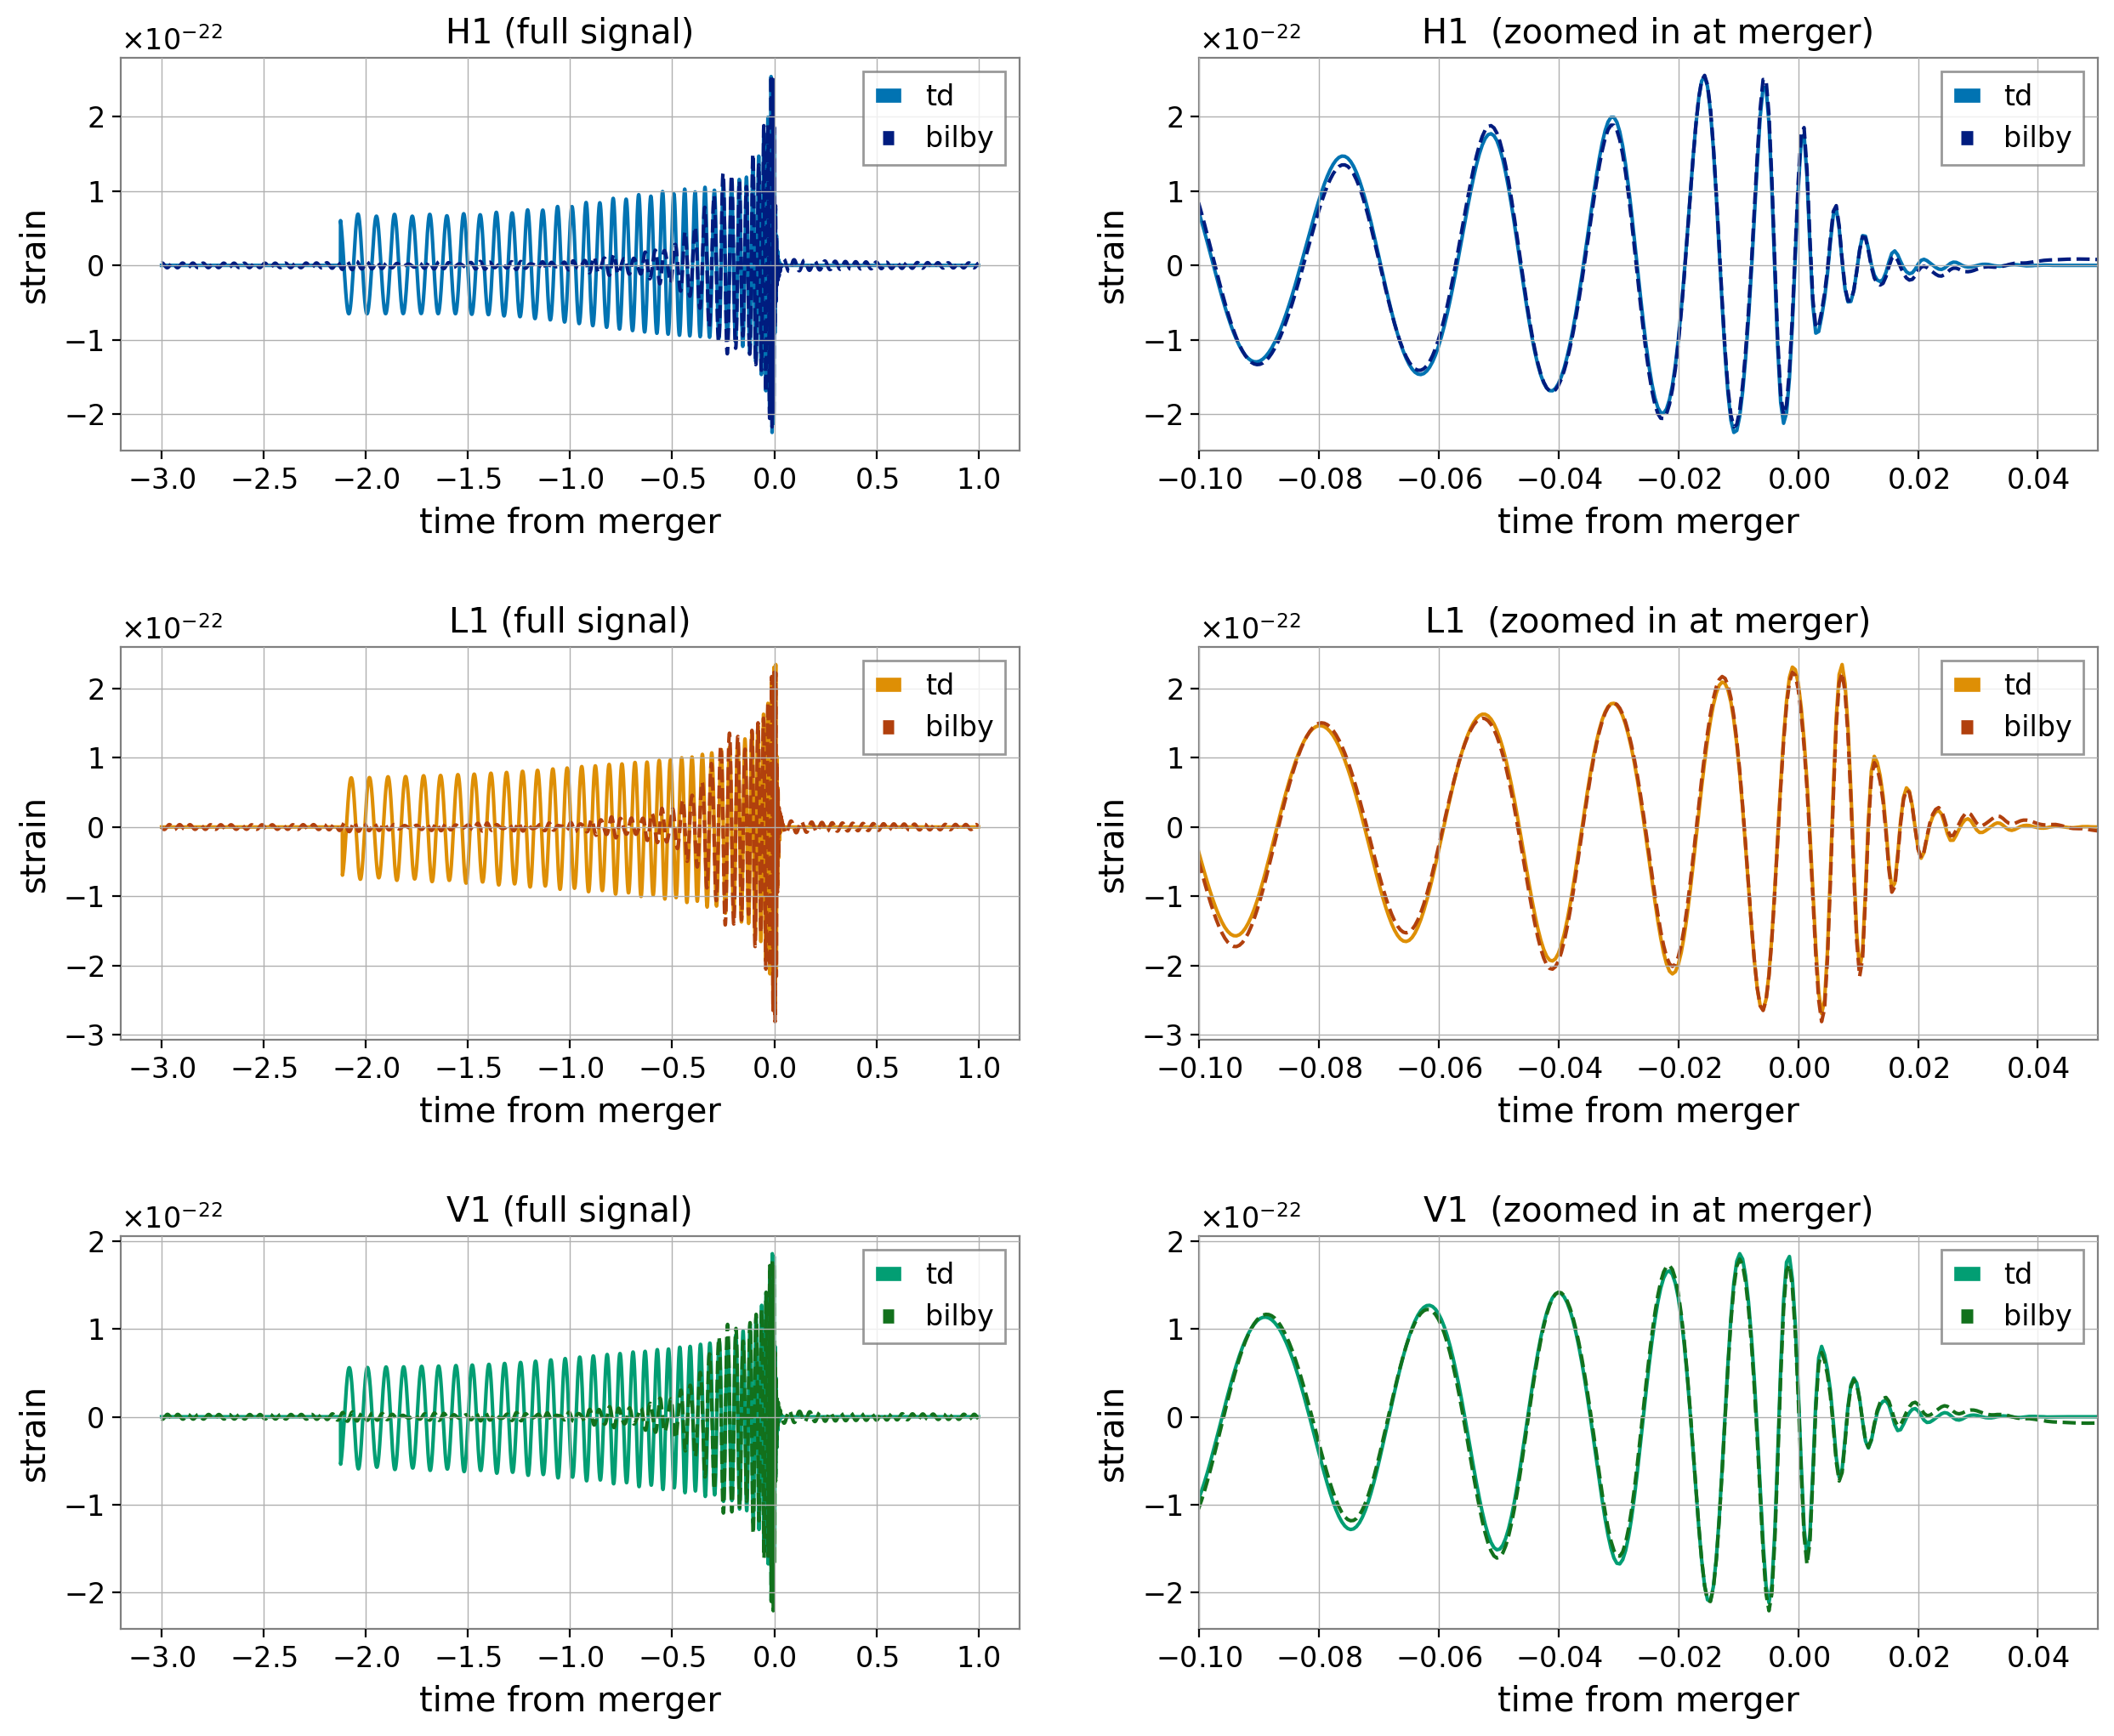

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

for i, ifo in enumerate(ifos): 

    for ax in axes[i]:
        
        # td
        ax.plot(time_dict[ifo] - injection['geocenter_time'], h_ifos_td[ifo], color=cmap1[i], label='td')
        
        # bilby    
        ax.plot(ifo_list_bilby[i].time_array -injection['geocenter_time'] , ifo_list_bilby[i].time_domain_strain, color=cmap2[i], ls='--', label='bilby')
        
        ax.set_xlabel('time from merger')
        ax.set_ylabel('strain')
        ax.legend()

    axes[i][0].set_title(ifo+' (full signal)')
    axes[i][1].set_title(ifo+'  (zoomed in at merger)')

    axes[i][1].set_xlim(-0.1, 0.05)
        
plt.subplots_adjust(hspace=0.5)
plt.show()

They do not agree because of how `bilby` makes time-domain waveforms within the `inject_signal` function. There is a sharp bandpass filter below the `minimum_frequency`. Let's process the waveforms from the time-domain code in the same way. To do this, we window the signals, FFT them, allow a sharp cutoff at the `minimum_frequency`, and then inverse FFT back to the time domain. 

In [17]:
bilby_freq_array = ifo_list_bilby[0].power_spectral_density.frequency_array
f_cutoff = max(bilby_freq_array[bilby_freq_array < ifo_list_bilby[0].minimum_frequency])
print(f_cutoff)

19.96898


^  this is the maximum zero-ed out frequency.

In [18]:
# Generate windowed version
h_ifos_td_windowed = wf_manager.get_projected_waveform(injection, ifos, time_dict, f22_start, f_ref, window=True)

# Get segment length and frequencies
Nt = len(h_ifos_td_windowed['L1'])
freqs = np.fft.rfftfreq(Nt, dt)

# FFT and cut out data below f_low and go back to TD
h_ifos_transformed = {}
for ifo, data in h_ifos_td_windowed.items():
    
    h_fd = np.fft.rfft(data)
    h_fd[freqs <= f_cutoff] = 0

    h_ifos_transformed[ifo] = np.fft.irfft(h_fd, n=Nt)

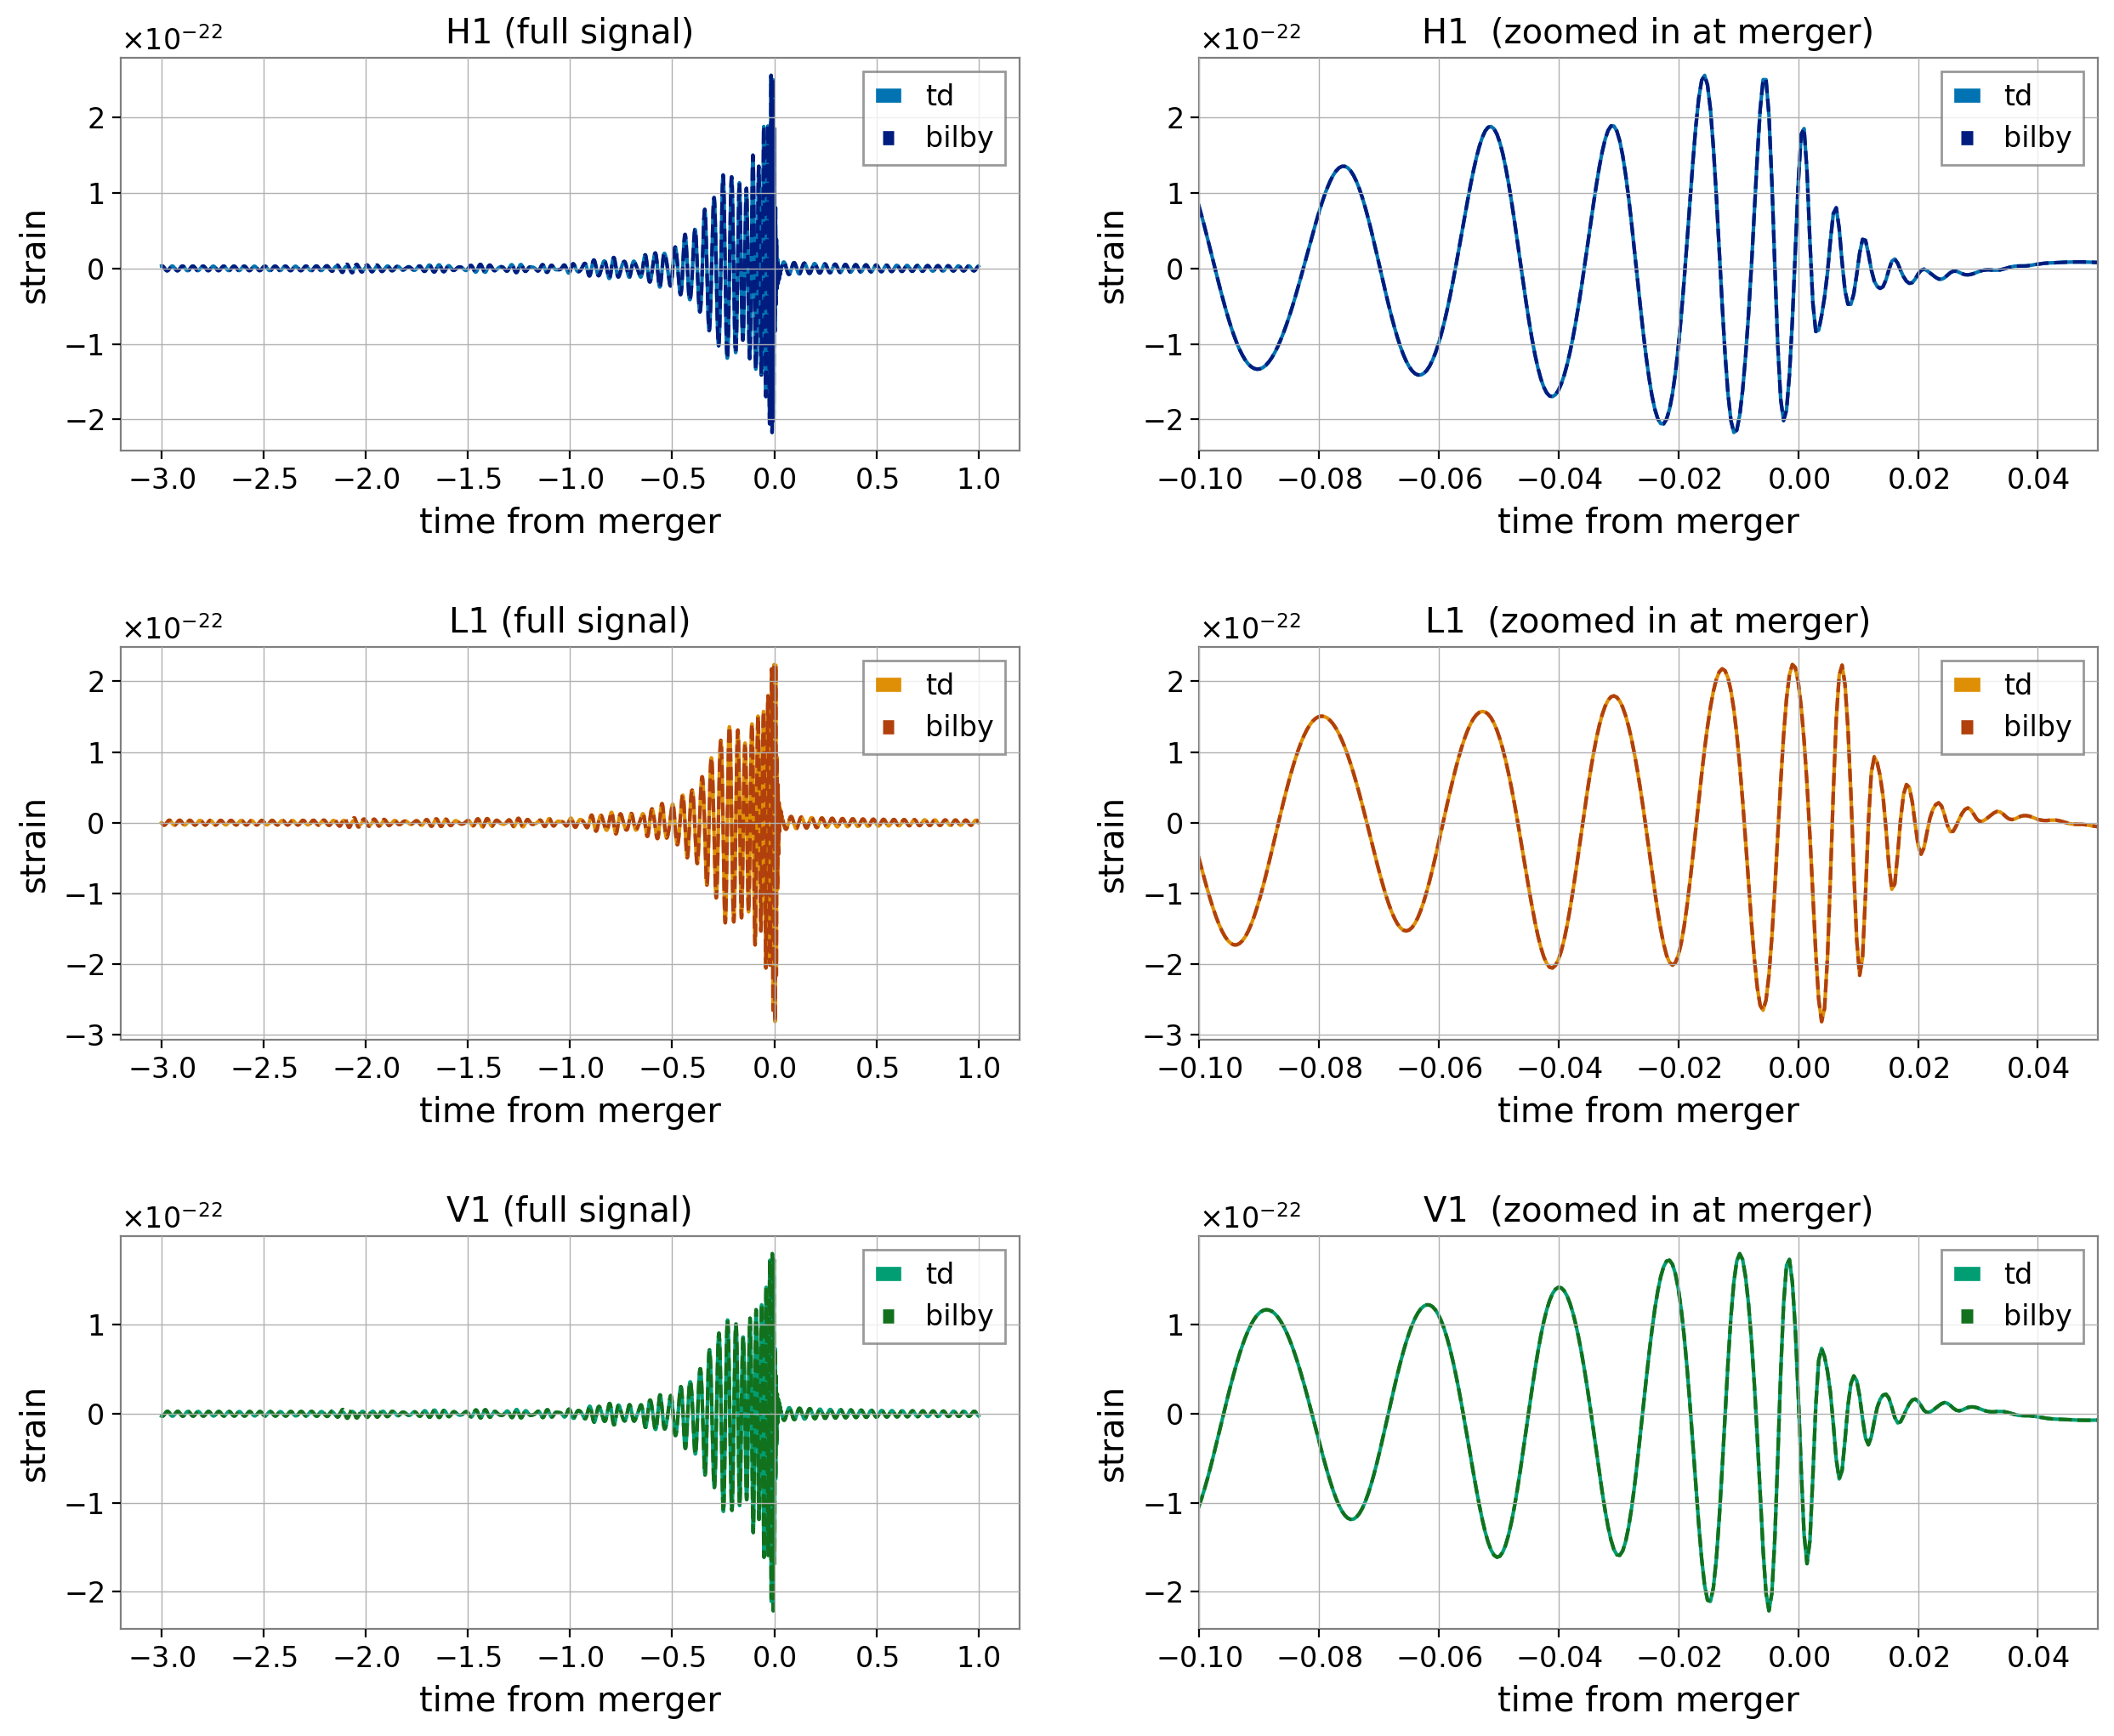

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

for i, ifo in enumerate(ifos): 

    for ax in axes[i]:
        
        # td
        ax.plot(time_dict[ifo] - injection['geocenter_time'], h_ifos_transformed[ifo], color=cmap1[i], label='td')
        
        # bilby    
        ax.plot(ifo_list_bilby[i].time_array -injection['geocenter_time'] , ifo_list_bilby[i].time_domain_strain, color=cmap2[i], ls='--', label='bilby')
        
        ax.set_xlabel('time from merger')
        ax.set_ylabel('strain')
        ax.legend()

    axes[i][0].set_title(ifo+' (full signal)')
    axes[i][1].set_title(ifo+'  (zoomed in at merger)')

    axes[i][1].set_xlim(-0.1, 0.05)
        
plt.subplots_adjust(hspace=0.5)
plt.show()

They agree!